In [1]:
import sys
import os

current_directory = os.getcwd()        
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from spektral.layers import GCNConv

from postprocess.threshold import flood_threshold, drought_threshold
from preprocess.BaselinePrerocess import baseline_process, baseline_process_for_gate_predictor
from preprocess.GraphTransformerPrerocess import graph_water_transformer_cov_process_for_gate_predictor
from preprocess.graph import graph_topology_5

import pygad
import time

2023-08-05 00:06:50.985637: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-05 00:06:52.591893: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

### Preprocess

In [4]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9
sigma2 = 0.1
epsilon = 0.5

In [5]:
train_cov, val_cov, test_cov, \
train_tws_reshape, val_tws_reshape, test_tws_reshape, \
train_gate_pump_y, val_gate_pump_y, test_gate_pump_y, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler, gate_scalar = graph_water_transformer_cov_process_for_gate_predictor(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')
train_tws/val_tws/test_tws: (77069, 5, 72) (9634, 5, 72) (19268, 5, 72) 
 train_cov/val_cov/test_cov: (77069, 96, 12) (9634, 96, 12) (19268, 96, 12) 
 train_ws_y/val_ws_y/test_ws_y: (77069, 96) (9634, 96) (19268, 96) 
  train_gate_pump_y/val_gate_pump_y/test_gate_pump_y: (77069, 24, 7) (9634, 24, 7) (19268, 24, 7)


In [6]:
train_adj_mat, val_adj_mat, test_adj_mat = graph_topology_5(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))

node_indices: [0 0 0 0 1 1 2 2 3 3 4 4] 
neighbor_indices: [1 2 3 4 0 2 0 1 0 4 0 3]
number of nodes: 5, number of edges: 12


### Select event

In [7]:
start_idx = 2610
end_idx = 2800
duration = end_idx - start_idx

In [8]:
ws1 = test_ws_y[start_idx:end_idx, :]
ws1 = ws_scaler.inverse_transform(ws1)
ws1.shape

(190, 96)

In [9]:
# plt.plot(ws1[:, 0], label='S1')
# plt.xlabel('Time', fontsize=18)
# plt.ylabel('S1 Water Stage', fontsize=18)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.legend(fontsize=14)
# plt.show()

### Get optimizable and not optimizable variables

In [10]:
# X = test_X_mask[start_idx:end_idx, :, :]
# X_1d = np.reshape(X, -1)

# print(X.shape)
# print(X_1d.shape)

In [11]:
# optimizable
gate_state = test_cov[start_idx:end_idx, :, 2:9]
gate_state_1d = np.reshape(gate_state, -1)

print(gate_state.shape)
print(gate_state_1d.shape)

(190, 96, 7)
(127680,)


In [12]:
# not optimizable
not_gate1 = test_cov[start_idx:end_idx, :, 0:2]

print(not_gate1.shape)

(190, 96, 2)


In [13]:
# not optimizable
not_gate2 = test_cov[start_idx:end_idx, :, 9:]

print(not_gate2.shape)

(190, 96, 3)


### GA

In [14]:
saved_model = load_model('../saved_models/WaLeF_gtn_p.h5', custom_objects={'GCNConv': GCNConv})

2023-08-05 00:07:02.136062: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1


In [15]:
def fitness_func(ga_instance, solution, solution_idx):
    # ================ gate penalty ================
    solution = np.reshape(solution, (duration, 96*7))
    gate_max = 1
    gate_min = 0
    
    gate_penalty_sum = 0
    for i in range(duration):
        for j in range(96*7):
            if (solution[i, j] > gate_max):
                penalty_gate = np.abs(solution[i, j] - gate_max)**2
            elif (solution[i, j] < gate_min):
                penalty_gate = np.abs(solution[i, j] - gate_min)**2
            else:
                penalty_gate = 0
            gate_penalty_sum += penalty_gate

    # ================ get input numpy of gate ================
    solution = np.reshape(solution, (duration, 96, 7))
    input_np = np.zeros(((duration, 96, 12)))
    input_np[:, :, 0:2] = not_gate1
    input_np[:, :, 2:9] = solution
    input_np[:, :, 9:] = not_gate2
    
    # ================ predict ws ================
    yhat = saved_model.predict([input_np, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
    #yhat = saved_model.predict(input_np, verbose=0)
    
    
    # ================ ws penalty ================
    y_max = 0.62
    y_min = 0.2
    
    ws_penalty_sum = 0
    for i in range (duration):
        for j in range (96):
            if (yhat[i, j] > y_max):
                penalty_ws = np.abs(yhat[i, j] - y_max) + 20*np.abs(yhat[i, j] - y_max)**2
            elif (yhat[i, j] < y_min):
                penalty_ws = np.abs(y_min - yhat[i, j])
                
            else:
                penalty_ws = 0
            
            ws_penalty_sum += penalty_ws
    
    # ================ gate penalty + ws penalty ================
    penalty_gate_ws_sum = 0.2*gate_penalty_sum + 2.0*ws_penalty_sum
    
    if penalty_gate_ws_sum == 0:
        fitness = 9999999999999
    else:
        fitness = 1.0 / penalty_gate_ws_sum
    return fitness

In [16]:
fitness_function = fitness_func

num_generations = 200
num_parents_mating = 16

sol_per_pop = 96
num_genes = len(gate_state_1d)

init_range_low = 0
init_range_high = 1

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 5

In [17]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_space = {'low': 0, 'high': 1})

In [18]:
start_time = time.perf_counter()
ga_instance.run()
cpu_time = time.perf_counter() - start_time
print(f"CPU time: {cpu_time} seconds")

2023-08-05 00:07:05.257307: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 5ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 3ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 3ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 3ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 3ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 3ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step


6/6 [==============================] - 0s 4ms/step
CPU time: 5119.102590311086 seconds


In [19]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

6/6 [==============================] - 0s 3ms/step
Parameters of the best solution : [0.46669467 0.79041033 0.83571054 ... 0.75920698 0.76215818 0.40196306]
Fitness value of the best solution = 0.1784772216373226


### Post-processing

In [20]:
best_gate = np.reshape(solution, (duration, 96, 7))

best_input = np.zeros(((duration, 96, 12)))
best_input[:, :, 0:2] = not_gate1
best_input[:, :, 2:9] = best_gate
best_input[:, :, 9:] = not_gate2

best_perf = saved_model.predict([best_input, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
best_perf = ws_scaler.inverse_transform(best_perf)

6/6 [==============================] - 0s 3ms/step


In [21]:
count = 0

for i in range (duration):
    for j in range (96):
        if best_perf[i, j] > 3.5:
            count += 1

print(count)

0


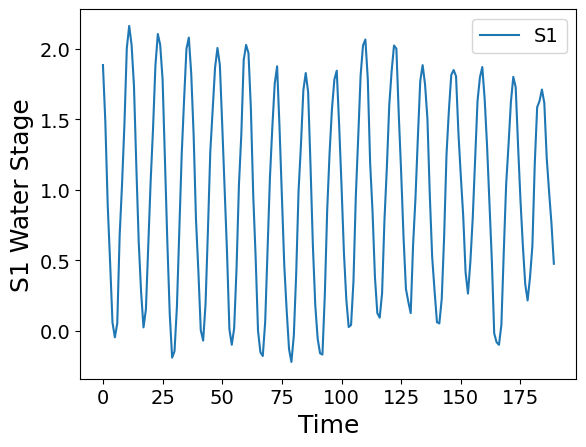

In [22]:
plt.plot(best_perf[:, 0], label='S1')
plt.xlabel('Time', fontsize=18)
plt.ylabel('S1 Water Stage', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [23]:
Optimal_gate = pd.DataFrame(best_gate.reshape(duration, -1) )
Optimal_gate.to_csv("GA_results/best_gate_event_low4.csv", index=False)
Optimal_gate

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,668,669,670,671
0,0.466695,0.790410,0.835711,0.761220,0.469549,0.755905,0.641695,0.537561,0.685492,0.972685,...,0.914525,0.014935,0.412270,0.832571,0.477993,0.699294,0.018052,0.431343,0.629934,0.402118
1,0.834608,0.413823,0.169593,0.180010,0.969922,0.144220,0.269815,0.037957,0.742636,0.699161,...,0.718286,0.110647,0.614856,0.393820,0.851730,0.715197,0.084131,0.201022,0.248697,0.928499
2,0.037414,0.916751,0.730539,0.941977,0.355892,0.285095,0.667660,0.907899,0.751955,0.300038,...,0.755957,0.151221,0.121428,0.449386,0.920013,0.423620,0.569177,0.532481,0.048960,0.298987
3,0.666846,0.407845,0.879617,0.894085,0.277842,0.267120,0.513094,0.332848,0.356762,0.004091,...,0.804031,0.350423,0.778264,0.953271,0.212402,0.635523,0.046407,0.821045,0.734151,0.613577
4,0.380369,0.704790,0.399412,0.009365,0.270195,0.014334,0.448249,0.574617,0.308503,0.105280,...,0.730019,0.847887,0.673422,0.658581,0.309222,0.544701,0.077123,0.957767,0.215960,0.360018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,0.900954,0.079434,0.424234,0.320989,0.821940,0.399330,0.312924,0.394575,0.281344,0.545874,...,0.679234,0.513507,0.641254,0.585438,0.602625,0.266999,0.786905,0.578306,0.468762,0.272831
186,0.593375,0.569662,0.571647,0.710640,0.135155,0.328141,0.341787,0.464363,0.665387,0.728968,...,0.159196,0.368389,0.376552,0.433346,0.457127,0.714704,0.108828,0.459040,0.967754,0.219609
187,0.560027,0.353818,0.751043,0.185787,0.999790,0.752084,0.243055,0.960216,0.936969,0.231328,...,0.696459,0.407934,0.835618,0.648367,0.617381,0.149666,0.818552,0.696716,0.506352,0.641319
188,0.685991,0.672931,0.130893,0.796565,0.268526,0.075979,0.853760,0.984776,0.320243,0.503570,...,0.136638,0.649571,0.777391,0.989025,0.049470,0.127277,0.484940,0.454962,0.908860,0.465563


In [24]:
Optimal_case = pd.DataFrame(best_perf)
Optimal_case.to_csv("GA_results/best_performance_event_low4.csv", index=False)
Optimal_case

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,1.885524,1.731630,1.867390,2.014197,1.301382,1.173514,1.210754,1.348487,0.933451,0.993158,...,1.412160,1.462391,1.747299,1.751319,1.787802,1.856888,1.939088,2.023374,1.990328,2.129971
1,1.481519,1.533277,1.540997,1.586391,0.893451,0.582439,0.946131,0.964781,0.469362,0.338057,...,1.674053,1.691428,1.955408,1.957073,2.033723,2.111345,1.942181,1.849794,2.001697,2.098767
2,0.889753,1.087583,0.928433,0.842001,0.356772,0.265887,0.404995,0.362228,0.069626,0.224793,...,1.911662,2.070156,1.889763,1.926823,1.960855,2.046611,1.620772,1.785789,1.725854,1.818739
3,0.485561,0.281147,0.604725,0.555912,-0.101101,0.210604,-0.110985,-0.103771,-0.110058,-0.368542,...,2.000178,2.084745,1.689317,1.475658,1.819434,1.839948,1.167448,1.327319,1.284049,1.272287
4,0.058178,0.243090,0.237619,0.043210,-0.036302,0.142446,0.165336,0.013531,0.000328,-0.007895,...,1.609669,1.785342,1.189471,1.172272,1.216933,1.324175,0.669557,0.843230,0.798819,0.780223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,1.615693,1.714110,1.633655,1.669374,1.257007,1.293784,1.235086,1.305923,1.042904,0.848693,...,1.233446,1.366133,1.567076,1.696910,1.592075,1.642075,1.764658,1.844871,1.769176,1.928478
186,1.228913,1.291930,1.213314,1.267105,0.946987,0.885925,0.905665,1.018036,0.710906,0.720204,...,1.552180,1.663647,1.750905,1.899746,1.825129,1.952297,1.902982,1.795785,1.931717,2.075972
187,0.986369,0.865976,1.050446,1.036251,0.671596,0.546625,0.597725,0.672032,0.504776,0.658627,...,1.823401,1.961406,1.863294,1.698828,1.927152,2.060717,1.814785,1.914075,1.835137,1.995453
188,0.760301,0.668740,0.850790,0.870592,0.367433,0.468490,0.384112,0.441712,0.248091,0.166978,...,1.863780,2.113728,1.830948,1.887642,1.887951,2.066189,1.503474,1.697300,1.570899,1.727703


In [25]:
upper_threshold = 3.5
lower_threshold = 0

Optimal_case_reshape = Optimal_case.to_numpy().reshape((-1, 24, 4))

flood_threshold(Optimal_case_reshape, upper_threshold)
drought_threshold(Optimal_case_reshape, lower_threshold)


time steps: 0, areas: 0
time steps: 510, areas: 44.23936575940752


In [ ]:
true_ws = saved_model.predict([test_cov[start_idx:end_idx], test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
true_ws = ws_scaler.inverse_transform(true_ws)

true_ws = true_ws.reshape((-1, 24, 4))
flood_threshold(true_ws, upper_threshold)
drought_threshold(true_ws, lower_threshold)